In [1]:
%cd ~/PaddleSeg
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

/home/zifanwang/PaddleSeg


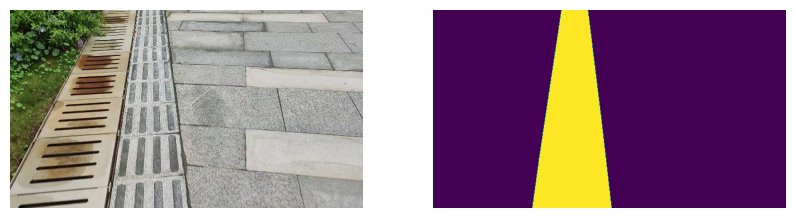

In [4]:

img_path = 'BlindpathDatasets/images'
mask_path = 'BlindpathDatasets/annotations'

image_list = os.listdir(img_path)
img_name = random.choice(image_list)
img = plt.imread(os.path.join(img_path,img_name))
mask = plt.imread(os.path.join(mask_path,img_name))
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img)
axs[1].imshow(mask[:,:,0])
for a in axs:
    a.axis('off')
plt.show()

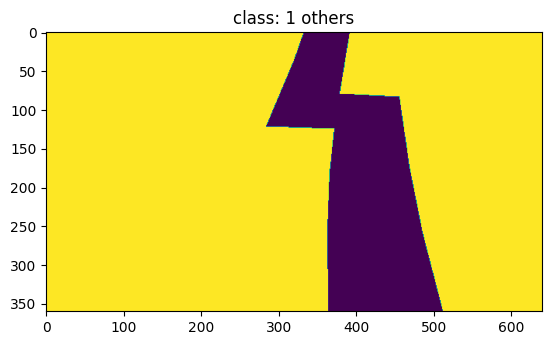

In [26]:
labels = ['blind sidewalks','others']
mask = plt.imread('BlindpathDatasets/mask/pic341.png')*255
#如果等一i就为255其他为0   
mask = np.where(mask == 128, 128, 255)
#取mask
mask1 = mask[:,:,0]
plt.title(f'class: {1} {labels[1]}')
plt.imshow(mask1)
plt.show()

In [2]:
import paddle
import numpy as np
from paddleseg.core import predict
from paddleseg.cvlibs import manager, Config, SegBuilder
from paddleseg.transforms import Compose
from paddleseg.core import infer
from paddleseg.utils import get_sys_env, logger, get_image_list, utils,progbar, visualize
def preprocess(im_path, transforms):
    data = {}
    data['img'] = im_path
    data = transforms(data)
    data['img'] = data['img'][np.newaxis, ...]
    data['img'] = paddle.to_tensor(data['img'])
    return data

In [5]:
cfg = Config('../pp_liteseg_stdc1_camvid_960x720_10k.yml')
Image_path = '../BlindpathDatasets/images'
ModelPath = '../output/best_model/model.pdparams'
save_dir = '../output/pre_test'
builder = SegBuilder(cfg)
Model = builder.model
transforms = Compose(builder.val_transforms)
Image_list, Image_dir = get_image_list(Image_path)

2023-05-08 15:06:21 [WARNING]	Add the `num_classes` in train_dataset and val_dataset config to model config. We suggest you manually set `num_classes` in model config.
2023-05-08 15:06:21 [INFO]	Use the following config to build model
model:
  arm_out_chs:
  - 32
  - 64
  - 128
  backbone:
    pretrained: https://bj.bcebos.com/paddleseg/dygraph/PP_STDCNet1.tar.gz
    type: STDC1
  num_classes: 2
  seg_head_inter_chs:
  - 32
  - 64
  - 64
  type: PPLiteSeg


W0508 15:06:21.241396 1884952 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 11.7, Runtime API Version: 11.7
W0508 15:06:21.287755 1884952 gpu_resources.cc:91] device: 0, cuDNN Version: 8.4.


2023-05-08 15:06:24 [INFO]	Loading pretrained model from https://bj.bcebos.com/paddleseg/dygraph/PP_STDCNet1.tar.gz
2023-05-08 15:06:24 [INFO]	There are 145/145 variables loaded into STDCNet.


In [16]:
utils.load_entire_model(Model, ModelPath)
Model.eval()
nranks = paddle.distributed.get_world_size()
local_rank = paddle.distributed.get_rank()
logger.info("Start to predict...")
Image_list = [Image_list]
progbar_pred = progbar.Progbar(target=len(Image_list[0]), verbose=1)
color_map = visualize.get_color_map_list(256, custom_color=None)

2023-05-08 15:14:57 [INFO]	Loading pretrained model from /home/zifanwang/PaddleSeg/PaddleSeg/output/best_model/model.pdparams
2023-05-08 15:14:58 [INFO]	There are 250/250 variables loaded into PPLiteSeg.
2023-05-08 15:14:58 [INFO]	Start to predict...


In [29]:
PrePic = '/home/zifanwang/PaddleSeg/BlindpathDatasets/pre_test/pic601.png'

data = preprocess(PrePic, transforms)

In [32]:
with paddle.no_grad():
    pred, _ = infer.inference(
    Model,
    data['img'],
    trans_info=data['trans_info'],
    is_slide=False,
    stride=None,
    crop_size=None)
pred = paddle.squeeze(pred)
pred = pred.numpy().astype('uint8')

added_image = visualize.visualize(PrePic, pred, color_map, weight=0.6)

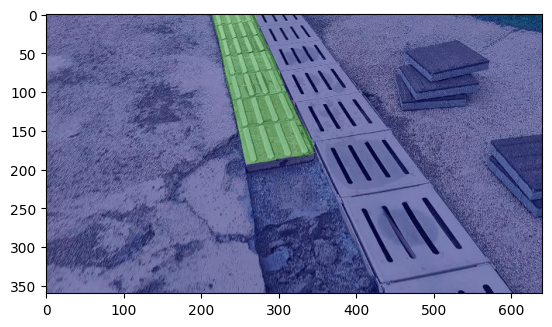

In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(added_image)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from IPython.display import clear_output, Image, display, HTML
import time
import cv2
import base64
current_time = 0
def processImg(img):
    # 画出一个框
    cv2.rectangle(img, (500, 300), (800, 400), (0, 0, 255), 5, 1, 0)
    # 上下翻转
    # img= cv2.flip(img, 0)

    # 显示FPS
    global current_time
    if current_time == 0:
        current_time = time.time()
    else:
        last_time = current_time
        current_time = time.time()
        fps = 1. / (current_time - last_time)
        text = "FPS: %d" % int(fps)
        cv2.putText(img, text , (0,100), cv2.FONT_HERSHEY_TRIPLEX, 3.65, (255, 0, 0), 2)
    
    return img

def arrayShow(imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))
